# FFun with FFT and sound files

Based on: https://realpython.com/python-scipy-fft/

Define a function for generating pure sine wave tones

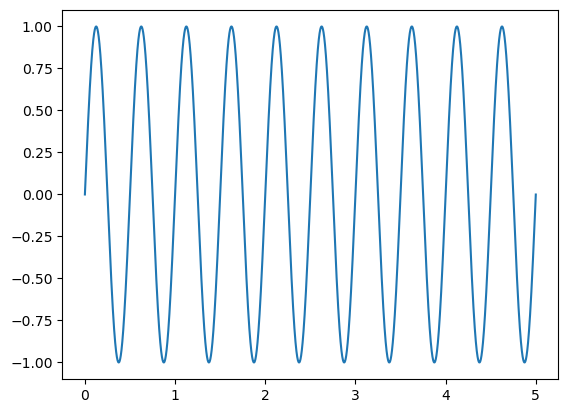

In [1]:
import numpy as np
import matplotlib.pyplot as plt

SAMPLE_RATE = 44100  # Hertz
DURATION = 5  # Seconds

def generate_sine_wave(freq, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = x * freq
    # 2pi because np.sin takes radians
    y = np.sin(2 * np.pi * frequencies)
    return x, y

# Generate a 2 hertz sine wave that lasts for 5 seconds
x, y = generate_sine_wave(2, SAMPLE_RATE, DURATION)
plt.plot(x, y)
plt.show()

Produce two tones, e.g. 400 Hz signal and a 4 kHz high-pitch noise

In [49]:
_, nice_tone = generate_sine_wave(440, SAMPLE_RATE, DURATION)
_, noise_tone = generate_sine_wave(4000, SAMPLE_RATE, DURATION)
noise_tone = noise_tone * 0.3

mixed_tone = nice_tone + noise_tone
#mixed_tone = nice_tone

For the purposes of storing the tones in an audio file, the amplitude needs to be normalized to the range of 16-bit integer

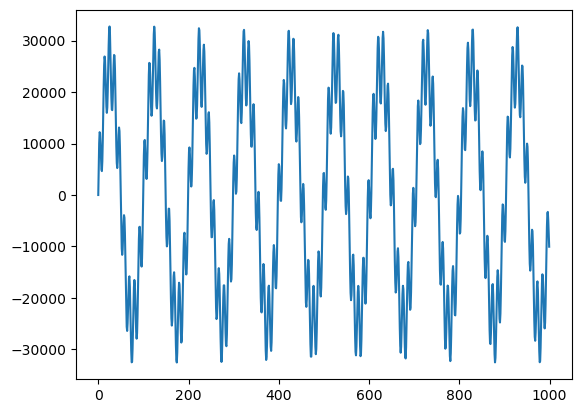

In [50]:
normalized_tone = np.int16((mixed_tone / mixed_tone.max()) * 32767)

plt.plot(normalized_tone[:1000])
plt.show()

Store the sound for playback

In [48]:
from scipy.io import wavfile as wf

# Remember SAMPLE_RATE = 44100 Hz is our playback rate
wf.write("mysinewave.wav", SAMPLE_RATE, normalized_tone)


Can also try to record the sound (NB: won't work on datahub ! Also only works in Terminal on MacOS > 13.0

In [10]:
# import required libraries 
%pip install sounddevice
import sounddevice as sd 

print("Recording...")

# Start recorder with the given values 
# of duration and sample frequency 
recording = sd.rec(int(DURATION * SAMPLE_RATE), samplerate=SAMPLE_RATE, channels=1) 

# Record audio for the given number of seconds 
sd.wait() 

print("Done")

# This will convert the NumPy array to an audio 
# file with the given sampling frequency 
wf.write("recording0.wav", SAMPLE_RATE, recording) 


Note: you may need to restart the kernel to use updated packages.
Recording...
Done


### Fourier transforms

Now try to transform the time stream into frequency space using FFT

Type of the output array:  <class 'numpy.complex128'>
Size of the input array:  131072
Size of the Fourier transform:  131072
Width of the frequency bins: 0.336456298828125 Hz


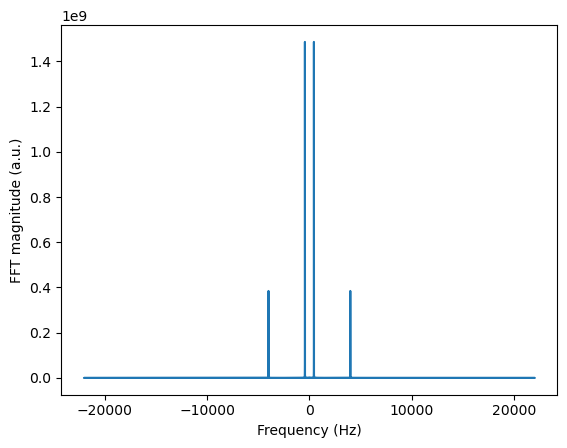

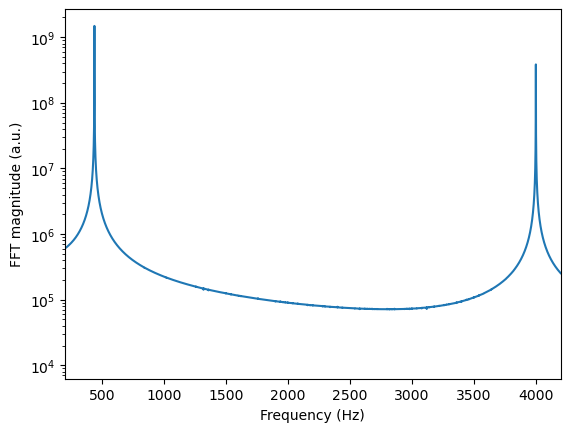

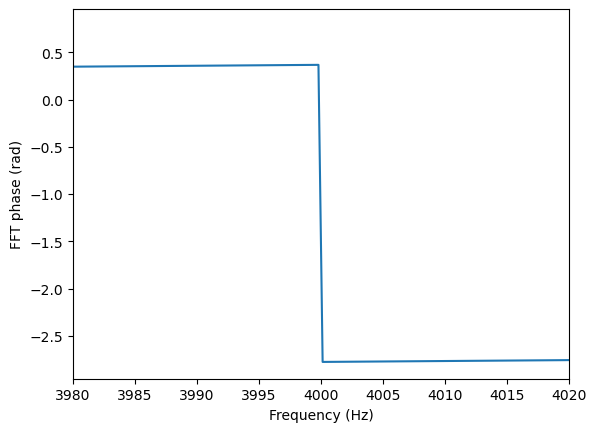

In [53]:
from scipy.fft import fft, fftfreq

# Number of samples in normalized_tone
N = SAMPLE_RATE * DURATION
Nw = 128*1024 # FFT works best when number of samples is a power of 2 !

yf = fft(normalized_tone[:Nw])   # Discrete Fourier transform
xf = fftfreq(Nw, 1 / SAMPLE_RATE)  # array of frequencies used for FFT
print('Type of the output array: ',type(yf[0]))
print('Size of the input array: ',Nw)
print('Size of the Fourier transform: ',len(xf))
df = xf[1]-xf[0]
print(f'Width of the frequency bins: {df} Hz')

plt.plot(xf, np.abs(yf))
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT magnitude (a.u.)')
plt.show()

plt.figure()
plt.yscale('log')
plt.plot(xf[:int(Nw/2)], np.abs(yf[:int(Nw/2)]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT magnitude (a.u.)')
plt.xlim(200,4200)
plt.show()

plt.figure()
plt.plot(xf[:int(Nw/2)],np.angle(yf[:int(Nw/2)]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT phase (rad)')
plt.xlim(3980,4020)
plt.show()

You notice that fft returns data for both positive and negative frequencies, produces the output array of the same size as input, and the output is a set of *complex* numbers. However, the information is reduntant: only half of the output values are unique. The magnitudes of the Fourier coefficients at negative frequencies are the same as at the corresponding positive frequencies. This is the property of the *real* Fourier transform, i.e. the transform applied to real-value signals. More precisely, $\mathrm{fft}(f)=\mathrm{fft}^*(-f)$

In [42]:
print(xf[1],xf[-1])
print(yf[1],yf[-1])

0.336456298828125 -0.336456298828125
(193235.1121548334+287.72765161969505j) (193235.1121548334-287.72765161969505j)


We can use this fact to save computational time and storage by computing only half of the Fourier coefficients:

Type of the output array:  <class 'numpy.complex128'>
Size of the input array:  220500
Size of the Fourier transform:  65537
Width of the frequency bins: 0.336456298828125 Hz


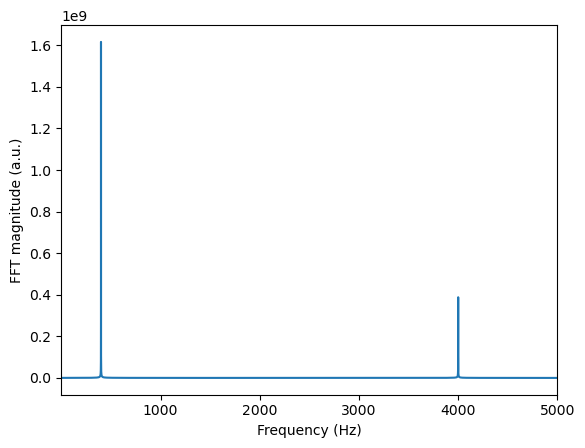

In [43]:
from scipy.fft import rfft, rfftfreq

# Note the extra 'r' at the front
yf = rfft(normalized_tone[:Nw])
xf = rfftfreq(Nw, 1 / SAMPLE_RATE)
print('Type of the output array: ',type(yf[0]))
print('Size of the input array: ',N)
print('Size of the Fourier transform: ',len(xf))
df = xf[1]-xf[0]
print(f'Width of the frequency bins: {df} Hz')

plt.plot(xf, np.abs(yf))
plt.xlim(1,5000)
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT magnitude (a.u.)')
plt.show()


Now let's look at the Fourier transorm of a recorded sound:

44100 220500


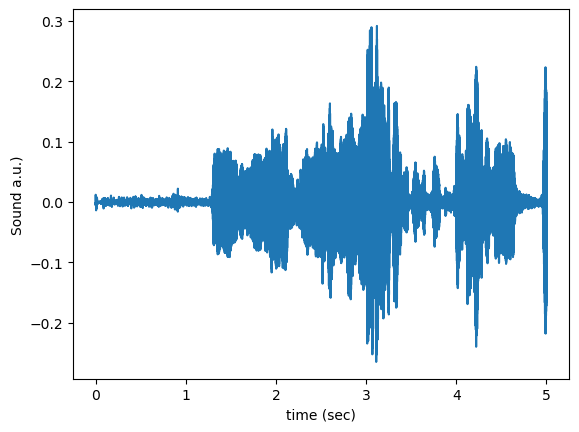

Type of the output array:  <class 'numpy.complex64'>
Size of the input array:  220500
Size of the Fourier transform:  110251
Width of the frequency bins: 0.2 Hz


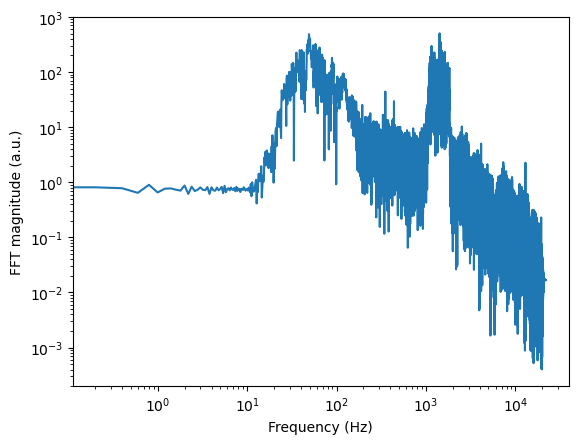

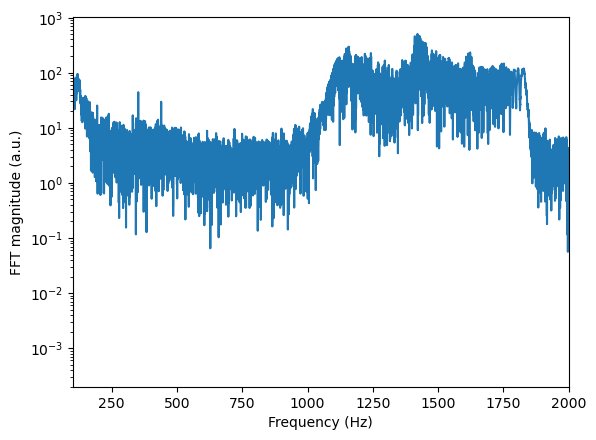

Frequency of loudest tone: 1421.2


In [54]:
rate, data = wf.read("recording0.wav")
N=len(data)
print(rate, N)
time=np.arange(0, N)/rate

plt.plot(time, data)
plt.xlabel('time (sec)')
plt.ylabel('Sound a.u.)')
plt.show()

yf = rfft(data)
xf = rfftfreq(len(data), 1 / rate)
print('Type of the output array: ',type(yf[0]))
print('Size of the input array: ',len(data))
print('Size of the Fourier transform: ',len(xf))
df = xf[1]-xf[0]
print(f'Width of the frequency bins: {df} Hz')

mag = np.abs(yf)

plt.figure()
plt.loglog(xf, mag)
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT magnitude (a.u.)')
plt.show()

plt.figure()
plt.plot(xf, mag)
plt.yscale('log')
plt.xlim(100,2000)
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT magnitude (a.u.)')
plt.show()

fMax = xf[np.argmax(mag)]
print(f'Frequency of loudest tone: {fMax}')

See for example a chart of fundamental frequencies of notes <a href="https://pages.mtu.edu/~suits/notefreqs.html">here</a>